Step4_Train_LR_Multi_Model_1_PCA，

用KNN演算法進行健康指標計算與故障分類

In [ ]:
# Step4_Train_LR_Multi_Model_1_PCA using Logistic Regression
# 使用KNN演算法進行健康指標計算與故障分類
# 使用存檔於myFeature資料夾下的特徵矩陣
# 並以PCA降維篩選2個關鍵特徵
# Author: Yuan-Jen Chang, Feng Chia University, imCLOUD CO.,LTD.
# Date: Sep. 18 2024

# Importing the libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define directories
currentDirectory = '/content/drive/MyDrive/PHM_2024_Group6' # root Directory
healthyDataDirectory='/content/drive/MyDrive/PHM_2024_Group6/Data/Training/Healthy'
faulty1DataDirectory='/content/drive/MyDrive/PHM_2024_Group6/Data/Training/Faulty1'
faulty2DataDirectory='/content/drive/MyDrive/PHM_2024_Group6/Data/Training/Faulty2'
testingDataDirectory='/content/drive/MyDrive/PHM_2024_Group6/Data/Testing'
csvDirectory='/content/drive/MyDrive/PHM_2024_Group6/csv'
featureDirectory='/content/drive/MyDrive/PHM_2024_Group6/myfeature'

In [ ]:
# 讀取檔案
os.chdir(featureDirectory) # Change directory to feature file directory
dataset1 = pd.read_csv('featureHealthy.csv') # (48, 80)
dataset2 = pd.read_csv('featureFaulty.csv') # (96, 80)
#dataset2 = pd.read_csv('featureFaulty1.csv') # (48, 80)
#dataset2 = pd.read_csv('featureFaulty2.csv') # (48, 80)
dataset3 = pd.read_csv('featureTesting.csv')# (36, 80)
dataset4 = pd.read_csv('training_allFeature.csv')# (144, 80)

shape1=dataset1.shape
shape2=dataset2.shape
shape3=dataset3.shape
shape4=dataset4.shape

len1=shape1[1]  # Totally 80 features
m1=shape1[0] # m1 = 48 ; about Healthy
m2=shape2[0] # m2 = 96 ; about Faluty
m3=shape3[0] # m3 = 36 ; about Testing


feature_name=dataset1.columns.values.tolist() #取得特徵名稱

In [ ]:
# m1 = 48
# m2 = 96
# len1 = 80
# 多故障分類之資料框順序: faulty1 -> faulty2 -> healthy

########## Get the healthy and faulty features from feature directory ##########

featureHealthy = dataset1.iloc[:, :].values  #Healthy features
featureFaulty = dataset2.iloc[:, :].values  #Faulty features
featureTesting = dataset3.iloc[:, :].values  #Faulty features

featureAll = np.zeros((m1+m2, len1), dtype=np.double) #(144, 80) # m1 = 48, m2 = 96
featureAll[0:m1,:]=featureHealthy[0:m1,:] #Healthy dataset = 48
featureAll[m1:m1+m2,:]=featureFaulty[0:96,:] #Faulty dataset = 96

# healthy label: 1
# faulty1 label: 2
# faulty2 label: 3

labelAll=np.zeros((m1+m2,1), dtype=np.double)  # 144 labels for training data

## Training data
labelAll[0:m1,0] =1  # Healthy label = 1; [0:48] assigned 1

labelAll[m1:m1+48,0] =2  # Faulty1 label  = 2 ; [48:96] assigned 2
labelAll[m1+48:m1+48*2,0] =3 # Faulty2 label  = 3; [96:144] assigned 3


X_train0 = featureAll[:,:] #Training set of X. The features: y-rms , v-mean
y_train = labelAll  #Training set of y. The labels

#  Test set
X_test0 = featureTesting[:,:] # The features:
y_test=np.zeros((m3,1), dtype=np.double) # m3 testing data
y_test[0:12,0] = 2  # Have known Faulty1 label = 2 (已知答案)
y_test[12:24,0] = 3  # Have known Faulty2 label = 3 (已知答案)
y_test[24:36,0] = 1  # Have known Healthy label = 1 (已知答案)


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  # Standarderize all training data
X_train = sc.fit_transform(X_train0)
X_test = sc.transform(X_test0)

In [ ]:
# Apply PCA dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components = 2,random_state=0)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_

In [ ]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [ ]:
# Caculate the probability of the Test set results
y_CV=classifier.predict_proba(X_test)
y_CV_train=classifier.predict_proba(X_train)


# Predict the Test set results
y_pred = classifier.predict(X_test) # Predict the label using testing data


In [ ]:
# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)  #Calculate confusion matrix
accuracy = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / np.sum(cm)
print("%4s  %6s  %5s %6.2f %1s" % ("使用KNN + 特徵 PCA-1", ", PCA-2", "正確率：", accuracy * 100, "%"))

使用KNN + 特徵 PCA-1  , PCA-2   正確率：  97.22 %


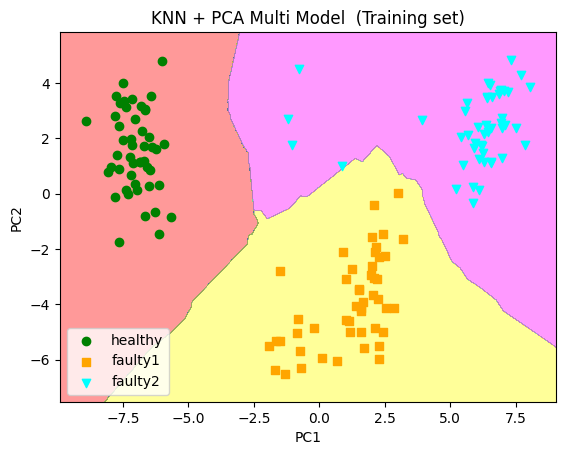

In [ ]:
# Visualize the Training set results
from matplotlib.colors import ListedColormap
#cmap = ListedColormap(['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#fc8f54', '#00ffff', '#ff00ff'])
cmap = ListedColormap(['red', 'green', 'blue', 'yellow', 'orange', 'cyan', 'magenta'])

plt.figure()
X_set, y_set = X_train, y_train[:,0]
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.4, cmap = ListedColormap((['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#fc8f54', '#00ffff', '#ff00ff'])))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
#                 cmap = cmap(i), label = str(round(j)))
plt.scatter(X_set[48*0:48*1,0], X_set[48*0:48*1,1], marker='o', c='green',  label='healthy', alpha=1)
plt.scatter(X_set[48*1:48*2,0], X_set[48*1:48*2,1], marker='s', c='orange',  label='faulty1', alpha=1)
plt.scatter(X_set[48*2:48*3,0], X_set[48*2:48*3,1], marker='v', c='cyan',  label='faulty2', alpha=1)

plt.title('KNN + PCA Multi Model  (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


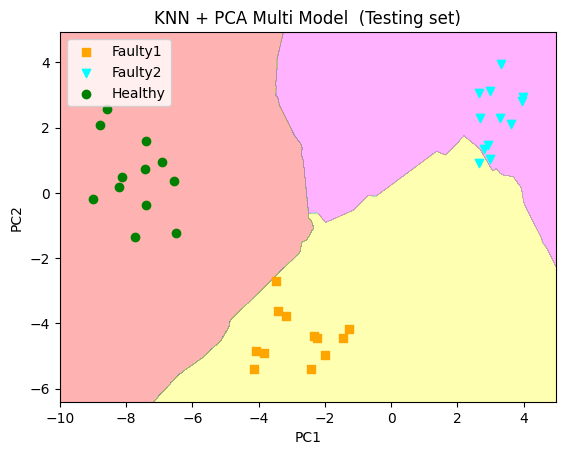

In [ ]:
# Visualising the Test set results
from matplotlib.colors import ListedColormap
plt.figure();
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.3, cmap = ListedColormap((['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#fc8f54', '#00ffff', '#ff00ff'])))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
plt.scatter(X_set[0:12,0], X_set[0:12,1], marker='s', c='orange',  label='Faulty1', alpha=1)
plt.scatter(X_set[12:24,0], X_set[12:24,1], marker='v', c='cyan',  label='Faulty2', alpha=1)
plt.scatter(X_set[24:36,0], X_set[24:36,1], marker='o', c='green',  label='Healthy', alpha=1)

plt.title('KNN + PCA Multi Model  (Testing set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()
